In [65]:
#We start by importing the libraries we need for this research project

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import math
import random
from tabulate import tabulate
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn import tree, model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
! pip install xgboost
import xgboost as xgb
import time
import statsmodels.api as sm

In [66]:
data=pd.read_csv('SBAnational.csv',low_memory=False,parse_dates=['ApprovalDate','DisbursementDate','ChgOffDate'])

In [67]:
# We can see that we have 899164 instances and 27 columns
data.shape


(899164, 27)

In [68]:
#This is the variable that we will use for prediction
#PIF represents loans that were paid in full while
#CHGOFF are loans that were charged off
#In this dataset we have four times more paid in full loans than defaulted loans
#The dataset is very imbalanced
data.value_counts('MIS_Status')


MIS_Status
P I F     739609
CHGOFF    157558
dtype: int64

# DATA CLEANING

In [69]:
#Dealing with NAs
#We check how many null values are present in the dataset
#and remove the null values that represent less than 5% of the total data
print(data.isna().sum())
threshold = len(data) * 0.05
print(threshold)

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64
44958.200000000004


In [70]:
#We create a variable containing the missing values
drop_cols = data.columns[data.isna().sum()<= threshold]

# Then we eliminate the missing values that represent less than the 5% of the total data
data.dropna(subset=drop_cols, inplace=True)
print(data.isna().sum())

LoanNr_ChkDgt             0
Name                      0
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr                 0
LowDoc                    0
ChgOffDate           725369
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64


In [71]:
#We have to fix the data types and change some of them from strings to floats
data[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = \
data[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

data = data.astype({'DisbursementGross': 'float', 'BalanceGross': 'float',
                          'ChgOffPrinGr': 'float', 'GrAppv': 'float', 'SBA_Appv': 'float'})

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886240 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      886240 non-null  int64         
 1   Name               886240 non-null  object        
 2   City               886240 non-null  object        
 3   State              886240 non-null  object        
 4   Zip                886240 non-null  int64         
 5   Bank               886240 non-null  object        
 6   BankState          886240 non-null  object        
 7   NAICS              886240 non-null  int64         
 8   ApprovalDate       886240 non-null  datetime64[ns]
 9   ApprovalFY         886240 non-null  object        
 10  Term               886240 non-null  int64         
 11  NoEmp              886240 non-null  int64         
 12  NewExist           886240 non-null  float64       
 13  CreateJob          886240 non-null  int64   

In [72]:
# Now we have to check that our variables don't contain input errors
#In this case we have the year 1976 with an extra A
data['ApprovalFY'].apply(type).value_counts()
data['ApprovalFY'].unique()

def drop_a(x):
    if isinstance(x, str):
        return x.replace('A', '')
    return x


data['ApprovalFY'] = data['ApprovalFY'].apply(drop_a).astype('int64')

In [73]:
#We create a new column to represent each industry using the first two digits of the NAICS

data['Industry'] = data['NAICS'].astype('str').apply(lambda x: x[:2])

data['Industry'] = data['Industry'].map({
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'})

#Remove the records with null values

data.dropna(subset=['Industry'], inplace=True)


In [74]:
#We create a new numeric column to represent each industry using the first two digits of the NAICS

data['Industry_type'] = data['NAICS'].astype('str').apply(lambda x: x[:2])

data['Industry_type'] = data['Industry_type'].map({
    '11': 1,
    '21': 2,
    '22': 3,
    '23': 4,
    '31': 5,
    '32': 6,
    '33': 7,
    '42': 8,
    '44': 9,
    '45': 10,
    '48': 11,
    '49': 12,
    '51': 13,
    '52': 14,
    '53': 15,
    '54': 16,
    '55': 17,
    '56': 18,
    '61': 19,
    '62': 20,
    '71': 21,
    '72': 22,
    '81': 23,
    '92': 24})

#Remove the records with na values

data.dropna(subset=['Industry_type'], inplace=True)


In [75]:
data.dtypes

LoanNr_ChkDgt                 int64
Name                         object
City                         object
State                        object
Zip                           int64
Bank                         object
BankState                    object
NAICS                         int64
ApprovalDate         datetime64[ns]
ApprovalFY                    int64
Term                          int64
NoEmp                         int64
NewExist                    float64
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                 int64
UrbanRural                    int64
RevLineCr                    object
LowDoc                       object
ChgOffDate           datetime64[ns]
DisbursementDate     datetime64[ns]
DisbursementGross           float64
BalanceGross                float64
MIS_Status                   object
ChgOffPrinGr                float64
GrAppv                      float64
SBA_Appv                    float64
Industry                    

In [76]:
# To improve the accuracy of my predictors, I will cut the records after 2010 since loans terms are usually over 5 years
# but this dataset stops at 2014, if I leave it it will have more unpaid loans than expected and would affect the prediction
#quality of the models

data = data[data['ApprovalFY'] <= 2010]

# We create a variable that will take into account the years of the Great Recession
rec = [2007,2008,2009]
data['Recession'] = data['ApprovalFY'].isin(rec)
data['Recession'] = data['Recession'].astype(str)
data['Recession'] = data['Recession'].replace({'False':'0','True':'1'},regex=True).astype(int)


In [77]:
#Remove records with input errors in the columns New Exist and UrbanRural, meaning that we will remove items different to 1 and 2

data['NewExist'].unique()
data = data[(data['NewExist'] == 1) | (data['NewExist'] == 2)]

data['UrbanRural'].unique()
data = data[(data['UrbanRural'] == 1) | (data['UrbanRural'] == 2)]

In [78]:
#Remove records with input errors in the columns New Exist and UrbanRural, meaning that we will remove items different to Y and N
data['RevLineCr'].unique()
data['LowDoc'].unique()
#Revline and LowDoc have many input errors, let us remove them
data = data[(data['RevLineCr'] == 'Y') | (data['RevLineCr'] == 'N')]
data = data[(data['LowDoc'] == 'Y') | (data['LowDoc'] == 'N')]

# We change N and Y for 0 = No, 1 = Yes
data['RevLineCr'] = np.where(data['RevLineCr'] == 'N', 0, 1)
data['LowDoc'] = np.where(data['LowDoc'] == 'N', 0, 1)


In [79]:
#We create a new variable that we will use for predictions
#PAID is 1 when the loan is paid in full and 0 when it is not

DEFAULT=[]
for loan in data['MIS_Status']:
    if loan=='CHGOFF':
        DEFAULT.append(1)
    else:
        DEFAULT.append(0)
#We create a new column in the database "data" named "Default"        
data['DEFAULT']= DEFAULT

# shift column 'Default' to first position
first_column = data.pop('DEFAULT')
data.insert(0, 'DEFAULT', first_column)

In [80]:
#We check for empty values and notice that ChgOffDate has quite few null values
#Loans that were paid do not have a default date
#we will remove columns that we are not using for the exploratory analysis
print(data.isna().sum())
columns_to_drop = ['Name', 'City', 'State', 'Bank', 'BankState', 'Zip','LoanNr_ChkDgt']
data.drop(columns=columns_to_drop, inplace=True)

DEFAULT                   0
LoanNr_ChkDgt             0
Name                      0
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr                 0
LowDoc                    0
ChgOffDate           233888
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
Industry                  0
Industry_type             0
Recession                 0
dtype: int64


# Data Exploration

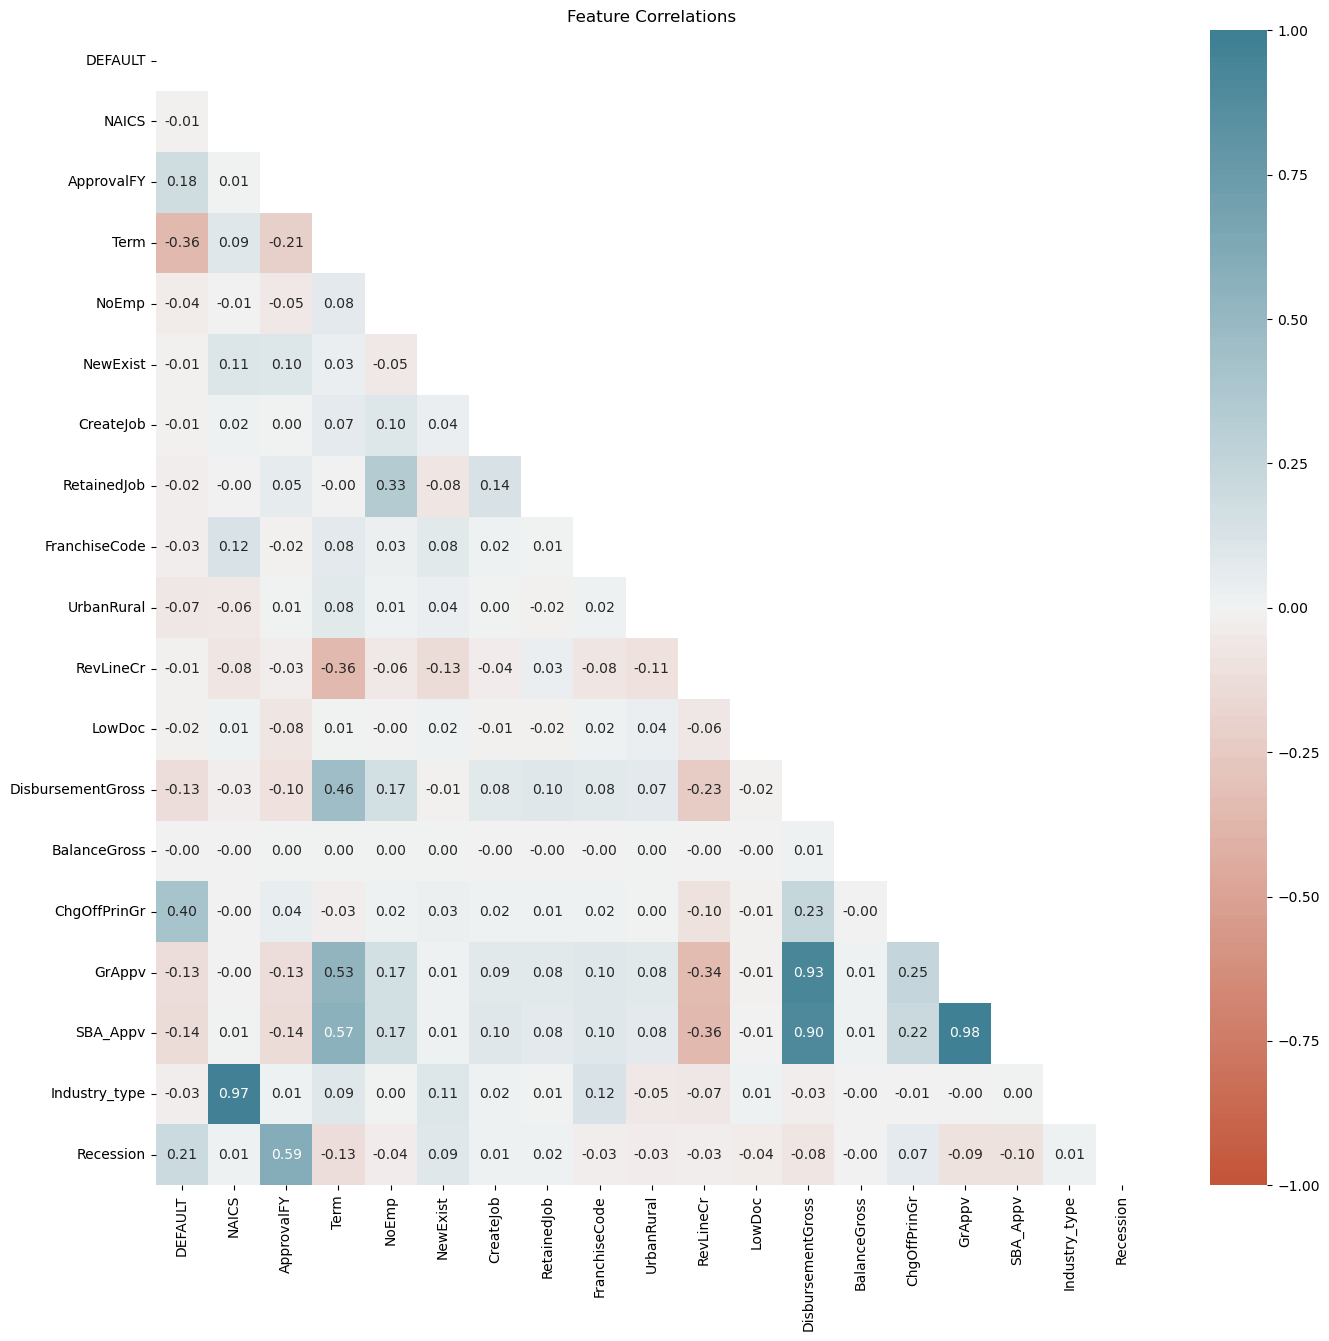

In [81]:
#We can see that many variables have no correlation with Default
corr = data.corr()
fig, ax = plt.subplots(figsize=(16,15))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-1,vmax=1,center=0, annot = True, fmt='.2f', ax=ax, mask=mask, cmap = sns.diverging_palette(20, 220, n=200)).set(title='Feature Correlations')
plt.show()

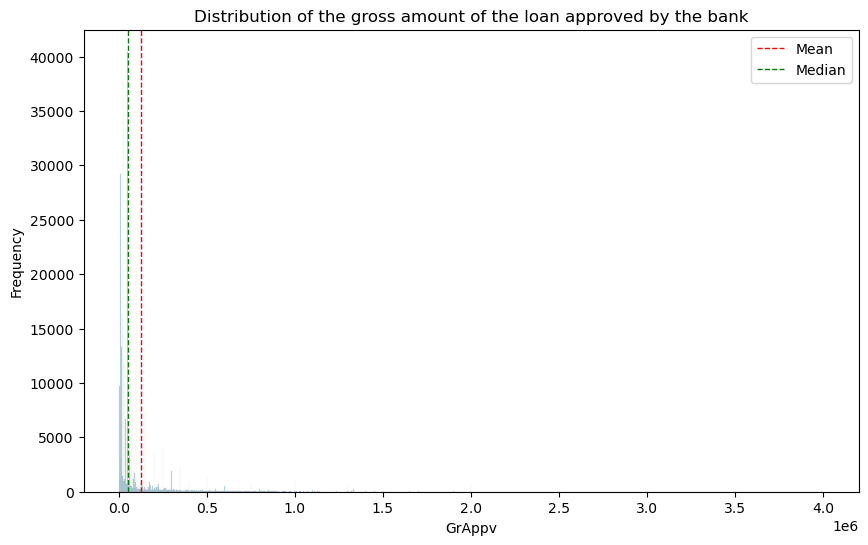

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(data['GrAppv'], kde=False)
plt.axvline(data['GrAppv'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(data['GrAppv'].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
plt.title('Distribution of the gross amount of the loan approved by the bank')
plt.xlabel('GrAppv')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [83]:
#we can see that the median approval gross is 50 000USD, the minimum is 1000 USD and the maximum 4 000 000 USD
print(data['GrAppv'].describe())

count    3.288510e+05
mean     1.282015e+05
std      2.388505e+05
min      1.000000e+03
25%      2.500000e+04
50%      5.000000e+04
75%      1.000000e+05
max      4.000000e+06
Name: GrAppv, dtype: float64


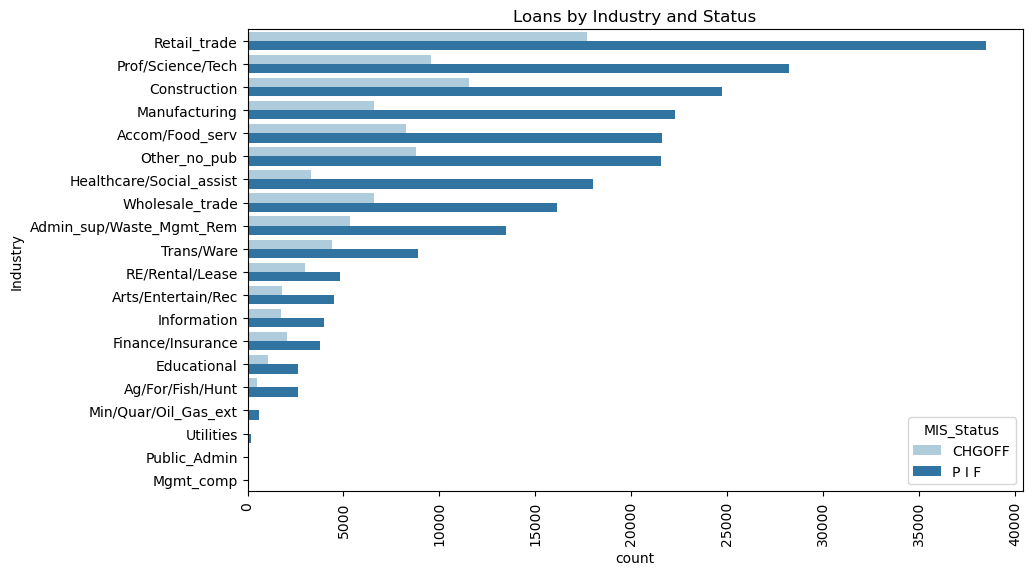

In [84]:
#Most loans were given to Retail, Science and Other. Also we can see that the sectors with higher default/paid ratio are lease,Transportation and Finance

max_counts = data.groupby(['Industry', 'MIS_Status']).size().reset_index(name='Count')
max_counts = max_counts.groupby('Industry')['Count'].max().reset_index(name='Max_Count')
sorted_industries = max_counts.sort_values(by='Max_Count', ascending=False)['Industry']


data['Industry'] = pd.Categorical(data['Industry'], categories=sorted_industries, ordered=True)
data = data.sort_values(by=['Industry', 'MIS_Status'])


fig, ax = plt.subplots(figsize=(10, 6))
chart = sns.countplot(data=data, y='Industry', hue='MIS_Status').set(title='Loans by Industry and Status')
sns.set_palette(sns.color_palette('Paired', n_colors=2)[::-1])  
plt.xticks(rotation='vertical')
plt.show()

In [85]:
#Table with default rates by Industry
def_rate = data.groupby(['Industry', 'DEFAULT'])['Industry'].count().unstack('DEFAULT')
def_rate['Default_rate'] = def_rate[1]/(def_rate[1] + def_rate[0])

def_rate['Default_rate'] = def_rate['Default_rate'].apply(lambda x: round(x, 3))


sorted_def_rate = def_rate.sort_values(by='Default_rate', ascending=False)
print(sorted_def_rate)

DEFAULT                       0      1  Default_rate
Industry                                            
RE/Rental/Lease            4805   3011         0.385
Finance/Insurance          3795   2079         0.354
Trans/Ware                 8868   4385         0.331
Public_Admin                 53     25         0.321
Construction              24751  11519         0.318
Retail_trade              38469  17671         0.315
Mgmt_comp                    52     23         0.307
Information                3989   1761         0.306
Wholesale_trade           16105   6596         0.291
Other_no_pub              21543   8756         0.289
Educational                2623   1061         0.288
Arts/Entertain/Rec         4488   1785         0.285
Admin_sup/Waste_Mgmt_Rem  13471   5316         0.283
Accom/Food_serv           21610   8241         0.276
Utilities                   190     72         0.275
Prof/Science/Tech         28229   9545         0.253
Manufacturing             22272   6615        

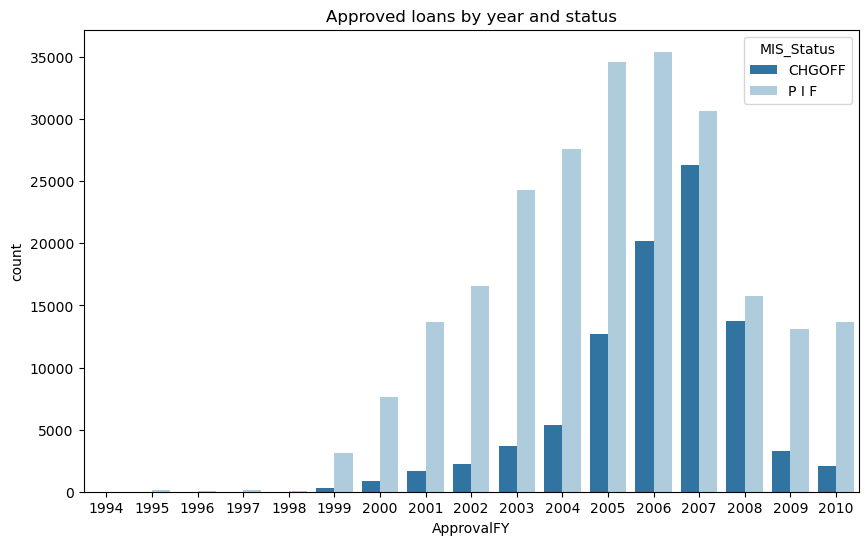

In [86]:
f, ax = plt.subplots(figsize=(10,6))
sns.countplot(x="ApprovalFY", data=data,hue='MIS_Status').set(title='Approved loans by year and status')
sns.set_palette("Paired")
plt.show()

In [87]:
# Default rate during recession
def_gr = data.groupby(['Recession', 'DEFAULT'])['Recession'].count().unstack('DEFAULT')
def_gr['Def_Percent'] = def_gr[1]/(def_gr[1] + def_gr[0])
def_gr['Def_Percent'] = def_gr['Def_Percent'].apply(lambda x: round(x, 3))
def_gr

DEFAULT,0,1,Def_Percent
Recession,,,
0,176938,49073,0.217
1,59552,43288,0.421


In [88]:
#we can see that the median for the term is 84 months, the minimum is 0 months and the maximum 527 months
print(data['Term'].describe())

count    328851.000000
mean         81.507394
std          57.452701
min           0.000000
25%          49.000000
50%          84.000000
75%          84.000000
max         527.000000
Name: Term, dtype: float64


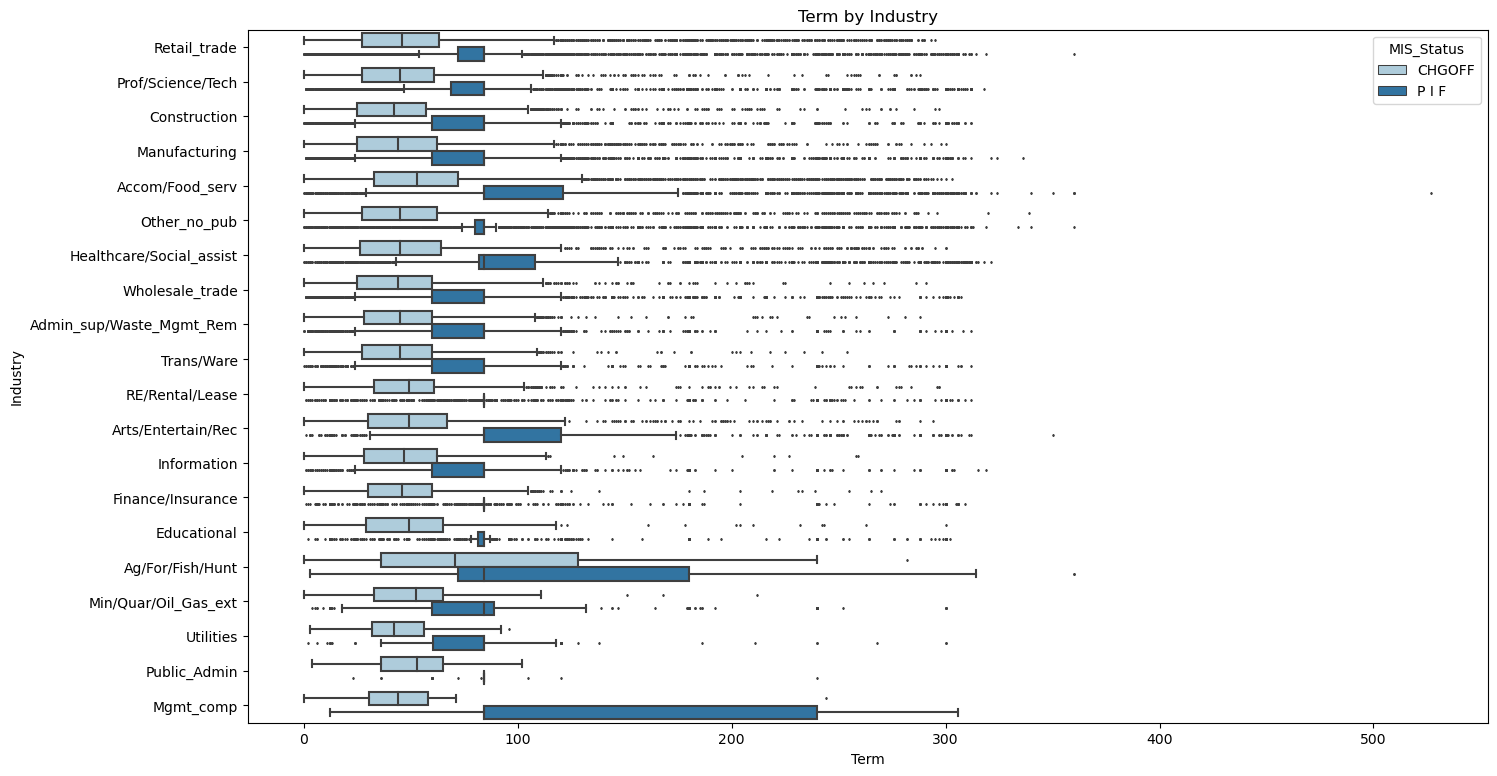

In [89]:
#There are many outliers and we can observe that many short term loans are more likely to be defaulted across all industries
fig, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=data, x='Term',y='Industry',hue='MIS_Status',fliersize=1).set(title='Term by Industry')
sns.set_palette('Paired')
plt.show()

In [90]:
# Create summary statistics for term by MIS_STATUS
summary_stats = data.groupby(['MIS_Status'])['Term'].describe()
table = tabulate(summary_stats, headers='keys', tablefmt='grid')

plt.show()
print(table)

+--------------+---------+---------+---------+-------+-------+-------+-------+-------+
| MIS_Status   |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
+==============+=========+=========+=========+=======+=======+=======+=======+=======+
| CHGOFF       |   92361 | 48.0048 | 33.7077 |     0 |    27 |    46 |    62 |   339 |
+--------------+---------+---------+---------+-------+-------+-------+-------+-------+
| P I F        |  236490 | 94.5918 | 59.4697 |     0 |    66 |    84 |    84 |   527 |
+--------------+---------+---------+---------+-------+-------+-------+-------+-------+


In [91]:
# We create a lower and upper limit for our outliers so we can remove them before modelling
seventy_fifth = data['GrAppv'].quantile(0.75)
twenty_fifth = data['GrAppv'].quantile(0.25)
gr_iqr = seventy_fifth - twenty_fifth


upper = seventy_fifth + (1.5 * gr_iqr)
lower = twenty_fifth - (1.5 * gr_iqr)

data[(data['GrAppv'] < lower) | (data['GrAppv'] > upper)][['Industry','Term','MIS_Status','GrAppv']]


,Industry,Term,MIS_Status,GrAppv
472,Retail_trade,52,CHGOFF,250000.0
1010,Retail_trade,208,CHGOFF,742000.0
1735,Retail_trade,166,CHGOFF,250000.0
11842,Retail_trade,149,CHGOFF,263000.0
12215,Retail_trade,39,CHGOFF,225000.0
...,...,...,...,...
527916,Mgmt_comp,240,P I F,1000000.0
541044,Mgmt_comp,240,P I F,259000.0
613429,Mgmt_comp,240,P I F,999000.0
638335,Mgmt_comp,240,P I F,515000.0


# DATA MODELING

After obtaining useful information from our exploratory analysis, we will make a simple feature selection and remove features that are not relevant and that might lower our accuracy.


In [92]:
# before starting with the model,we will remove the outliers first
data = data[(data['GrAppv'] >= lower) & (data['GrAppv'] <= upper)]

In [93]:
default_prob = sum(data.DEFAULT) / len(data)
print('After removing outliers')
print('Probability of defaulting is:', np.round(default_prob,2))
#If we label every loan as paid and could have obtained this accuracy
print('Accuracy to beat:',round(1-default_prob,2))
#BIG CLASS IMBALANCE

After removing outliers
Probability of defaulting is: 0.31
Accuracy to beat: 0.69


In [94]:
#After the exploratory analysis, now we know which columns to drop

columns_to_drop = ['ApprovalFY','BalanceGross','NAICS','ChgOffPrinGr','Industry', 'ApprovalDate', 'CreateJob', 'RetainedJob',
                   'FranchiseCode', 'DisbursementDate',
                   'MIS_Status','ChgOffDate']

data.drop(columns=columns_to_drop, inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 278693 entries, 67 to 824971
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DEFAULT            278693 non-null  int64  
 1   Term               278693 non-null  int64  
 2   NoEmp              278693 non-null  int64  
 3   NewExist           278693 non-null  float64
 4   UrbanRural         278693 non-null  int64  
 5   RevLineCr          278693 non-null  int32  
 6   LowDoc             278693 non-null  int32  
 7   DisbursementGross  278693 non-null  float64
 8   GrAppv             278693 non-null  float64
 9   SBA_Appv           278693 non-null  float64
 10  Industry_type      278693 non-null  int64  
 11  Recession          278693 non-null  int32  
dtypes: float64(4), int32(3), int64(5)
memory usage: 24.5 MB


# Decision Tree

In [95]:
#Decision Tree Algorithm
#We transform the colums of the dataset into features
Features = data.columns.tolist()

X=data.drop(['DEFAULT'],axis=1) 
X_names = Features[1:] 
y=data['DEFAULT'] 
y_names=['Paid','Defaulted']

#we set the test size to forty percent of our dataset. 
#Also, we set stratify to y so each portion of the dataset represents the overall dataset to combat the class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)  

import time

start_time = time.time()

decision_tree = tree.DecisionTreeClassifier(max_depth = 8, random_state=1) #The depth of three gives us the best accuracy
decision_tree.fit(X_train,y_train)
y_pred=decision_tree.predict(X_test)

# Model Accuracy

y_train_pred = decision_tree.predict(X_train)
print('Accuracy on training set:',round(metrics.accuracy_score(y_train, y_train_pred),2))
print('Accuracy on test set:',np.round(metrics.accuracy_score(y_test, y_pred),2))

end_time = time.time()
# Calculate and display the running time
running_time = end_time - start_time
print("Running time: {:.2f} seconds".format(running_time))

# Evaluate the model

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Confusion Matrix:')
print(conf_matrix)
print('Classification report:')
print(report)

# Feature importance
feature_importances_dict = {}
for i, name in enumerate(X_names): feature_importances_dict.update({name : decision_tree.feature_importances_[i]})

# Sort features in descending order of importance (need to use reverse=True for descending)  
feature_importances_sorted = dict(sorted(feature_importances_dict.items(), key=lambda x:x[1], reverse=True)) 

print('Features in order of importance:')   
for key in feature_importances_sorted:
    print(key)

Accuracy on training set: 0.91
Accuracy on test set: 0.91
Running time: 0.36 seconds
Confusion Matrix:
[[69781  7364]
 [ 2970 31363]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     77145
           1       0.81      0.91      0.86     34333

    accuracy                           0.91    111478
   macro avg       0.88      0.91      0.89    111478
weighted avg       0.91      0.91      0.91    111478

Features in order of importance:
Term
DisbursementGross
Recession
SBA_Appv
RevLineCr
GrAppv
UrbanRural
NewExist
NoEmp
Industry_type
LowDoc


In [96]:
#Decision Tree Algorithm
# Only visualize how the decision tree algorithm works, we will set the maximum depth to 3,
#Making it deeper make the visualization almost impossible, since it gets too complicated
import time

start_time = time.time()

decision_tree = tree.DecisionTreeClassifier(max_depth = 3, random_state=1) 
decision_tree.fit(X_train,y_train)
y_pred=decision_tree.predict(X_test)

# Model Accuracy

y_train_pred = decision_tree.predict(X_train)
print('Accuracy on training set:',round(metrics.accuracy_score(y_train, y_train_pred),2))
print('Accuracy on test set:',np.round(metrics.accuracy_score(y_test, y_pred),2))

end_time = time.time()
# Calculate and display the running time
running_time = end_time - start_time
print("Running time: {:.2f} seconds".format(running_time))

# Evaluate the model

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Confusion Matrix:')
print(conf_matrix)
print('Classification report:')
print(report)



Accuracy on training set: 0.85
Accuracy on test set: 0.85
Running time: 0.17 seconds
Confusion Matrix:
[[63024 14121]
 [ 2631 31702]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     77145
           1       0.69      0.92      0.79     34333

    accuracy                           0.85    111478
   macro avg       0.83      0.87      0.84    111478
weighted avg       0.88      0.85      0.85    111478



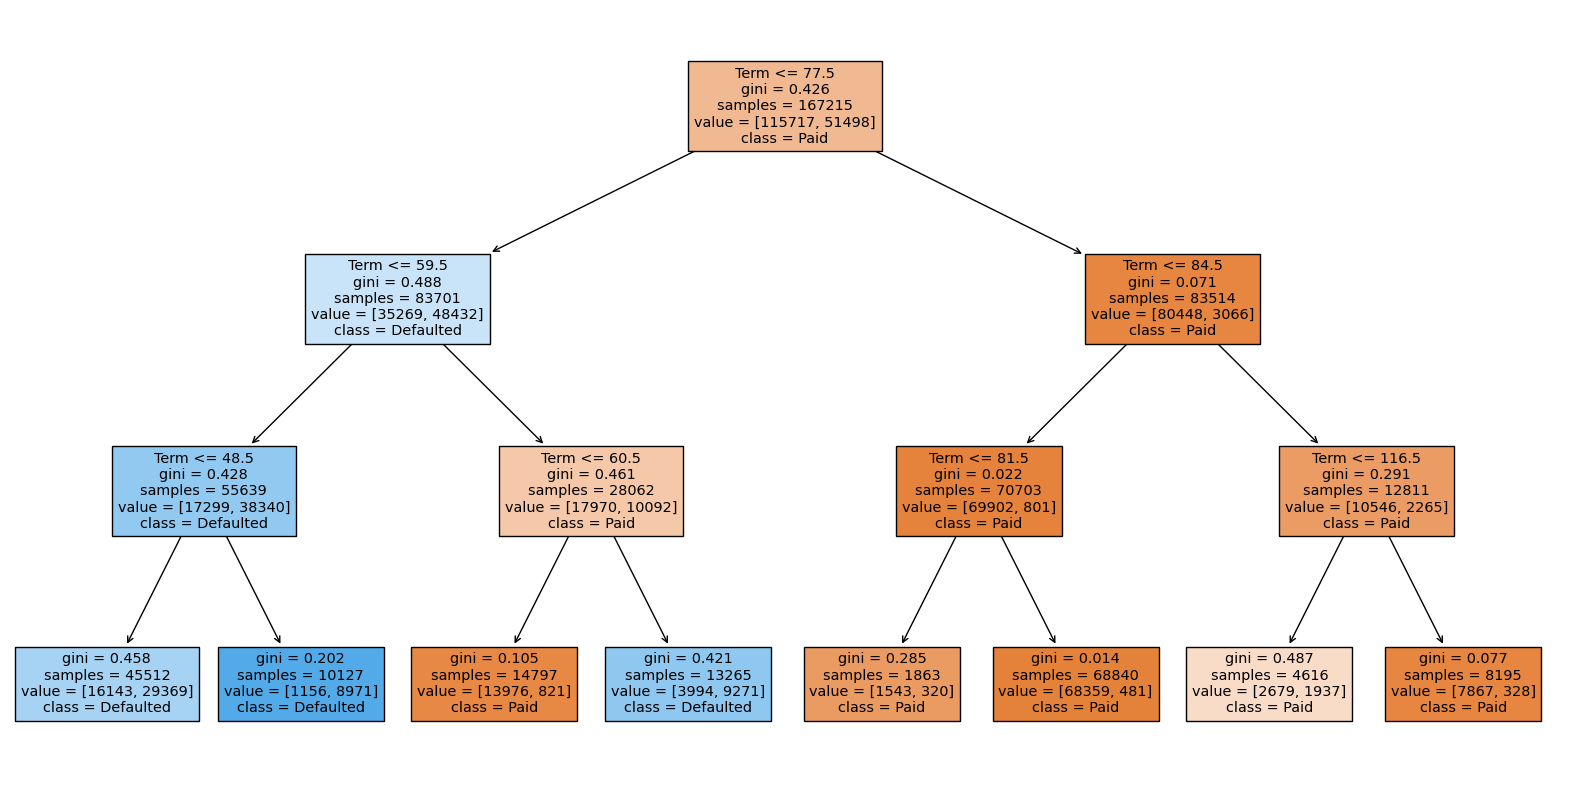

In [97]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(decision_tree,feature_names=X_names,class_names=y_names,filled=True)

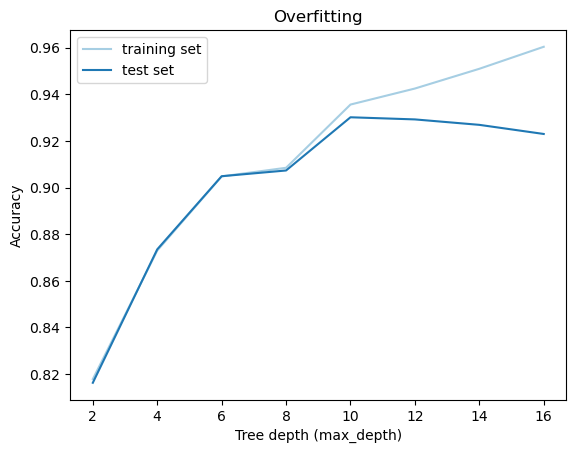

In [98]:
# Accuracy as a function of max_depth 

max_depth_vals = [2,4,6,8,10,12,14,16]
accuracytrain_list=[]
accuracytest_list=[]
for i in range(0,len(max_depth_vals)):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth_vals[i], random_state=i)
    decision_tree.fit(X_train,y_train)
    # Training set
    ytrain_pred = decision_tree.predict(X_train)
    accuracy_train = metrics.accuracy_score(y_train, ytrain_pred)
    accuracytrain_list.append(accuracy_train)
    # Test set
    ytest_pred = decision_tree.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, ytest_pred)
    accuracytest_list.append(accuracy_test)

# Plot accuracy as a function of max_depth

fig = plt.figure()
ax = plt.axes()
line1, = ax.plot(max_depth_vals,accuracytrain_list,label='training set')
line2, = ax.plot(max_depth_vals,accuracytest_list,label='test set')
plt.legend(handles=[line1, line2])
plt.title("Overfitting")
plt.xlabel("Tree depth (max_depth)")
plt.ylabel("Accuracy")
plt.show()

In [99]:
# 5-fold cross-validation to compute the mean accuracy of a tree with max length of 8

maxDepth = 8
k=5
decision_tree = tree.DecisionTreeClassifier(max_depth=maxDepth, random_state=1)
cv_scores = cross_val_score(decision_tree, X, y, cv=k)
print('Cross-validation scores are:',cv_scores)

# Compute the average of the accuracies and its error
avg = sum(cv_scores)/len(cv_scores)
sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
print('Average performance for a tree depth of',maxDepth,'is:',np.round(avg*100,1),'+/-',np.round(sd*100,1),'%')

Cross-validation scores are: [0.91476345 0.90697716 0.89985468 0.8848362  0.91348811]
Average performance for a tree depth of 8 is: 90.4 +/- 1.2 %


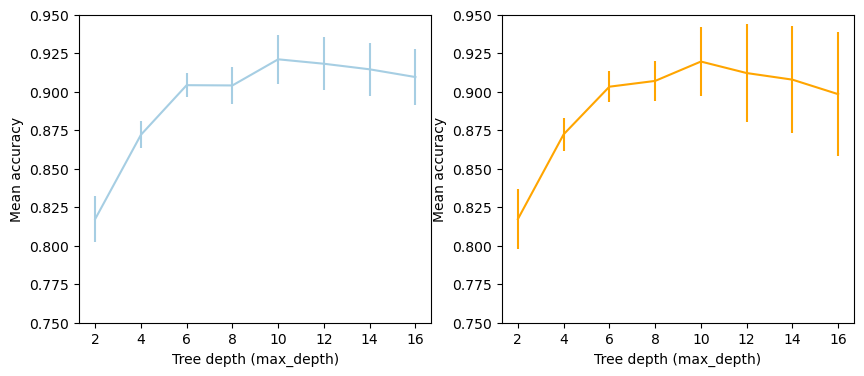

In [100]:
# 5-fold and 10 fold cross validation

max_depth_vals = [2,4,6,8,10,12,14,16]

### 5-fold ###
k=5
mean_accuracy_cv_k5 = [] # mean accuracy over the k folds for each tree depth
sd_cv_k5 = [] # standard deviation of accuracy scores over the k folds for each tree depth

for i in range(0,len(max_depth_vals)):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth_vals[i], random_state=i)
    cv_scores = cross_val_score(decision_tree, X, y, cv=k)
    avg = sum(cv_scores)/len(cv_scores)
    sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
    mean_accuracy_cv_k5.append(avg)
    sd_cv_k5.append(sd)
    
### 10-fold ###
k=10
mean_accuracy_cv_k10 = [] # mean accuracy over the k folds for each tree depth
sd_cv_k10 = [] # standard deviation of accuracy scores over the k folds for each tree depth

for i in range(0,len(max_depth_vals)):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth_vals[i], random_state=i)
    cv_scores = cross_val_score(decision_tree, X, y, cv=k)
    avg = sum(cv_scores)/len(cv_scores)
    sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
    mean_accuracy_cv_k10.append(avg)
    sd_cv_k10.append(sd)
    
# Make the plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].errorbar(max_depth_vals,mean_accuracy_cv_k5,yerr=sd_cv_k5)
ax[0].set_xlabel("Tree depth (max_depth)")
ax[0].set_ylabel("Mean accuracy")
ax[0].set_ylim([0.75,0.95])

ax[1].errorbar(max_depth_vals,mean_accuracy_cv_k10,yerr=sd_cv_k10, color="orange")
ax[1].set_xlabel("Tree depth (max_depth)")
ax[1].set_ylabel("Mean accuracy")
ax[1].set_ylim([0.75,0.95])

plt.show()

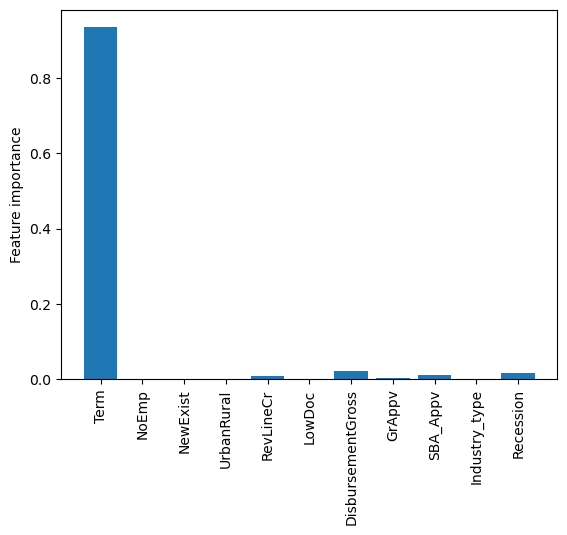

In [101]:
#To plot Feature Importance
def get_feature_importances(X,y,randomState,maxDepth):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, 
                                                                        random_state=randomState, stratify=y)  
    decision_tree = tree.DecisionTreeClassifier(max_depth = maxDepth, random_state=randomState)
    decision_tree.fit(X_train,y_train)
    return decision_tree.feature_importances_

maxDepth = 8
import random
random.seed(1)
feature_importances_summed = np.zeros(len(X_names))
n=100
for i in range(0,n):
    randomState = random.randint(0,1000)
    feature_importances = get_feature_importances(X,y,randomState,maxDepth)
    feature_importances_summed = feature_importances_summed + feature_importances
feature_importances_mean = [number / n for number in feature_importances_summed]

fig, ax = plt.subplots(1,1)
ax.bar(X_names, feature_importances_mean,color='tab:blue')
ax.set_ylabel('Feature importance')  
plt.xticks(rotation='vertical')
plt.show()

# Random Forest

In [102]:
start_time = time.time()
forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_features='auto',criterion='gini',max_depth=8,random_state=1,oob_score=True)
forest.fit(X_train,y_train)

y_train_pred = forest.predict(X_train)
print("Accuracy on training set:",round(metrics.accuracy_score(y_train, y_train_pred),2))
y_test_pred = forest.predict(X_test)
print("Accuracy on test set:",round(metrics.accuracy_score(y_test, y_test_pred),2))

end_time = time.time()

# Calculate and display the running time
running_time = end_time - start_time
print("Running time: {:.2f} seconds".format(running_time))

# Evaluate the model

conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification report:")
print(report)


Accuracy on training set: 0.88
Accuracy on test set: 0.88
Running time: 11.38 seconds
Confusion Matrix:
[[69261  7884]
 [ 5215 29118]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     77145
           1       0.79      0.85      0.82     34333

    accuracy                           0.88    111478
   macro avg       0.86      0.87      0.86    111478
weighted avg       0.89      0.88      0.88    111478



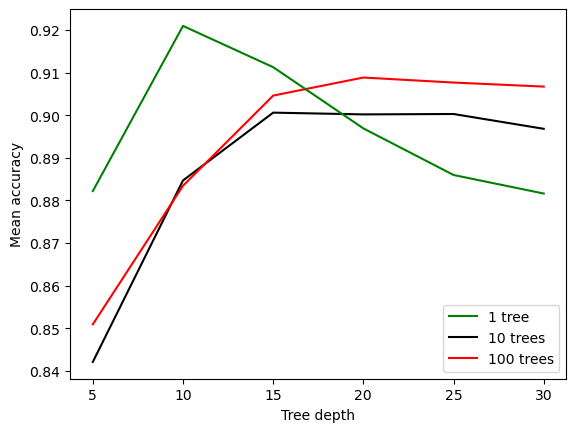

In [103]:
#Plot of mean performance of the random forest algorithm

max_depth_vals = [5,10,15,20,25,30]
n_estimators_vals = [10,100]
mean_accuracy_store = []
sd_accuracy_store = []
k=5
for i, value in enumerate(n_estimators_vals):
    mean_accuracy_cv = []
    sd_cv = []
    for val in max_depth_vals:
        forest = RandomForestClassifier(n_estimators=value,bootstrap=True,max_features='auto',criterion='gini',max_depth=val,random_state=i,oob_score=False)
        cv_scores = cross_val_score(forest, X, y, cv=k)
        avg = sum(cv_scores)/len(cv_scores)
        sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
        mean_accuracy_cv.append(avg)
        sd_cv.append(sd)
    mean_accuracy_store.append(mean_accuracy_cv)
    sd_accuracy_store.append(sd_cv)

fig = plt.figure()
ax = plt.axes()
line2, = ax.plot(max_depth_vals,mean_accuracy_store[0],color='black',label='10 trees')
line3, = ax.plot(max_depth_vals,mean_accuracy_store[1],color='red',label='100 trees')

# Now find accuracy scores as a function of tree depth for a single decision tree
mean_accuracy_cv = []
for i in range(0,len(max_depth_vals)):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth_vals[i], random_state=3)
    cv_scores = cross_val_score(decision_tree, X, y, cv=k)
    avg = sum(cv_scores)/len(cv_scores)
    mean_accuracy_cv.append(avg)
    
line1, = ax.plot(max_depth_vals,mean_accuracy_cv,color='green',label='1 tree')


plt.legend(handles=[line1, line2, line3])
plt.xlabel("Tree depth")
plt.ylabel("Mean accuracy")
plt.show()



# XGBoost

In [104]:
#XGBOOST MODEL
start_time = time.time()
xgb_model = xgb.XGBClassifier(max_depth=8)

#We fit the model to the test and training data defined when we developed the decision tree model
xgb_model.fit(X_train, y_train)

# Predictions on training and test sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

end_time = time.time()

# Calculate and display the running time
running_time = end_time - start_time
print("Running time: {:.2f} seconds".format(running_time))

# accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Accuracy on training set:", round(train_accuracy, 2))
print("Accuracy on test set:", round(test_accuracy, 2))

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification report:")
print(report)

Running time: 6.45 seconds
Accuracy on training set: 0.95
Accuracy on test set: 0.94
Confusion Matrix:
[[73350  3795]
 [ 3157 31176]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     77145
           1       0.89      0.91      0.90     34333

    accuracy                           0.94    111478
   macro avg       0.93      0.93      0.93    111478
weighted avg       0.94      0.94      0.94    111478



In [105]:
# List the importance of each feature
for name, importance in sorted(zip(X.columns, xgb_model.feature_importances_), key=lambda x: x[1], reverse=True):
    print(name, '=', '{:.2f}'.format(importance))

Term = 0.59
RevLineCr = 0.10
Recession = 0.08
UrbanRural = 0.04
SBA_Appv = 0.04
DisbursementGross = 0.03
GrAppv = 0.03
LowDoc = 0.03
NewExist = 0.03
Industry_type = 0.02
NoEmp = 0.02


In [106]:
# 5-fold cross-validation to compute the mean accuracy of a tree with max length of 8

maxDepth = 8
k=5
xgb = xgb.XGBClassifier(max_depth=maxDepth, random_state=1)
cv_scores = cross_val_score(decision_tree, X, y, cv=k)
print('Cross-validation scores are:',cv_scores)

# Compute the average of the accuracies and its error
avg = sum(cv_scores)/len(cv_scores)
sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
print('Average performance for a XGBoost model of',maxDepth,'is:',np.round(avg*100,1),'+/-',np.round(sd*100,1),'%')


Cross-validation scores are: [0.89843736 0.87653169 0.88390534 0.8546593  0.89461409]
Average performance for a XGBoost model of 8 is: 88.2 +/- 1.7 %


# Logistic Regression

In [107]:
#Logistic Regression
start_time = time.time()
# Initialize the logistic regression model with penalty lasso to make feature selection, sets some coef to 0, c is the regularization strenght 
log_model = LogisticRegression(solver='liblinear',penalty='l1',C=10, class_weight='balanced')

#we stratify so each portion of the dataset represents the overall dataset because we have a great class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)  
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# To obtain Model accuracy
log_model.fit(X_train, np.ravel(y_train))
y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)

print("Accuracy on training set:",round(metrics.accuracy_score(y_train, y_train_pred),2))
print("Accuracy on test set:",round(metrics.accuracy_score(y_test, y_test_pred),2))

end_time = time.time()

# Calculate and display the running time
running_time = end_time - start_time
print("Running time: {:.2f} seconds".format(running_time))

# Evaluate the model

conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification report:")
print(report)

############################################################################################

Accuracy on training set: 0.79
Accuracy on test set: 0.79
Running time: 1.41 seconds
Confusion Matrix:
[[60789 16356]
 [ 6750 27583]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     77145
           1       0.63      0.80      0.70     34333

    accuracy                           0.79    111478
   macro avg       0.76      0.80      0.77    111478
weighted avg       0.82      0.79      0.80    111478



In [108]:
log_model.intercept_
log_model.coef_

array([[-2.12333366, -0.05186406, -0.09362475, -0.19142704, -0.39324891,
        -0.04756295,  0.10292983, -0.91952849,  0.78779782, -0.02086342,
         0.54329144]])

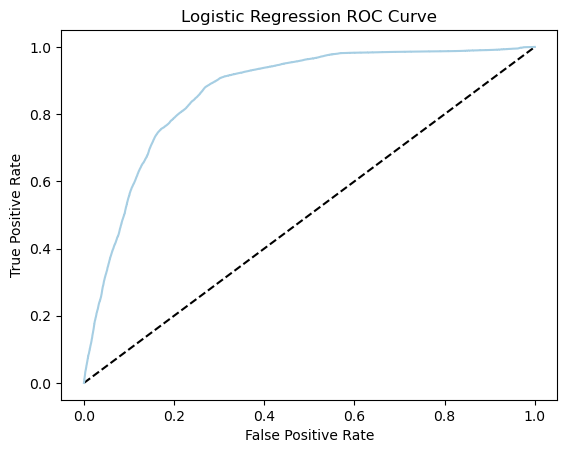

In [109]:
y_pred_probs = log_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0, 1], [0, 1],'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [110]:
#We start by fitting the logit stats model
logit_model=sm.Logit(y,X)
result=logit_model.fit()

# To obtain probabilities of the model
predicted_probs = result.predict(X)
predicted_classes = np.round(predicted_probs)


accuracy = np.mean(predicted_classes == y)

print("Accuracy:", accuracy)


print(result.summary2())
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.458061
         Iterations 7
Accuracy: 0.7709881482491487
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.258      
Dependent Variable:  DEFAULT          AIC:              255338.8994
Date:                2023-08-24 13:29 BIC:              255454.8159
No. Observations:    278693           Log-Likelihood:   -1.2766e+05
Df Model:            10               LL-Null:          -1.7209e+05
Df Residuals:        278682           LLR p-value:      0.0000     
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      7.0000                                        
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Term              -0.0446   0.0002 -224.6209 0.0000 -0.0450 -0.0442
NoEmp       